In [1]:
import sys
sys.path.append("../")

import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import matplotlib.cm as cmap
from tqdm import *
import torch
from torch import nn

from pytorch_lightning.loggers import TensorBoardLogger, MLFlowLogger
import mlflow

from utils.utils import ring2nest
from utils import create_mask as cm
from utils.psf_correction import PSFCorrection
from utils.templates import get_NFW2_template
from utils.plotting import make_plot, make_signal_injection_plot
from models.scd import dnds
from models.psf import KingPSF
from simulations.wrapper import simulator

from sbi import utils
from sbi import inference
from sbi.inference import PosteriorEstimator
from sbi import utils
from sbi import inference
from sbi.utils import x_shape_from_simulation

%matplotlib inline
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

In [2]:
import matplotlib.pylab as pylab
import warnings
import matplotlib.cbook

from plot_params import params

warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)

pylab.rcParams.update(params)
cols_default = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [3]:
import os

os.environ['KMP_DUPLICATE_LIB_OK']='True'

## Preliminaries

In [4]:
nside_list = [128, 64, 32, 16, 8, 4, 2]

In [5]:
hp_mask_nside1 = cm.make_mask_total(nside=1, band_mask = True, band_mask_range = 0,
                              mask_ring = True, inner = 0, outer = 25)

indexes_list = []
masks_list = []
for nside in nside_list:
    hp_mask = hp.reorder(hp.ud_grade(hp_mask_nside1, nside), r2n=True)
    masks_list.append(hp_mask)
    indexes_list.append(np.arange(hp.nside2npix(nside))[~hp_mask])

hp_mask_nside1 = hp.reorder(hp_mask_nside1, r2n=True)

In [6]:
# Load templates
temp_gce = np.load("../data/fermi_data/template_gce.npy")
fermi_exp = hp.reorder(np.load("../data/fermi_data/fermidata_exposure.npy"), r2n=True)

# Rescaling factor to remove exposure from PS templates
fermi_exp_ring = np.load("../data/fermi_data/fermidata_exposure.npy")
rescale = fermi_exp_ring / np.mean(fermi_exp_ring)

# Load GCE template
roi_normalize_temps = cm.make_mask_total(nside=128, band_mask = True, band_mask_range=2, mask_ring=True, inner=0, outer=30)
temp_gce = get_NFW2_template(gamma=1.2, exp_map=fermi_exp_ring, roi_normalize=roi_normalize_temps)

# Load other templates
temp_dif = np.load("../data/fermi_data/template_dif.npy")
temp_psc = np.load("../data/fermi_data/template_psc.npy")
temp_iso = np.load("../data/fermi_data/template_iso.npy")
temp_dsk = np.load("../data/external/template_disk_r_s_5_z_s_0.3.npy")
temp_bub = np.load("../data/fermi_data/template_bub.npy")

temp_mO_pibrem = np.load('../data/fermi_data/ModelO_r25_q1_pibrem.npy')
temp_mO_ics = np.load('../data/fermi_data/ModelO_r25_q1_ics.npy')

# PS mask
ps_mask = np.load("../data/mask_3fgl_0p8deg.npy")  

# Mask defining analysis ROI
roi_mask = hp.reorder(cm.make_mask_total(nside=128, band_mask = True, band_mask_range=2, mask_ring=True, inner=0, outer=25, custom_mask=ps_mask), r2n=True)

# ROI over which results are normalized
roi_mask_norm = hp.reorder(cm.make_mask_total(nside=128, band_mask = True, band_mask_range=2, mask_ring=True, inner=0, outer=25), r2n=True)

# ROI ove which simulations are created (nside=1 central pixel)
roi_sim = masks_list[0]

In [7]:
# Labels and templates for plotting / deriving physical quantities
poiss_labels = [r"Iso", r"Bub", r"3FGL", r"$\pi^0$/brem", r"ICS"]
ps_labels = [r"GCE PS", r"Disk PS"]
temps_poiss = hp.reorder([temp_iso, temp_bub, temp_psc, temp_mO_pibrem, temp_mO_ics], r2n=True)
temps_ps = hp.reorder([temp_gce / rescale , temp_dsk / rescale ], r2n=True)

In [8]:
temps_dict = {'fermi_exp':fermi_exp,
 'temps_ps':temps_ps,
 'temps_ps_sim':None,
 'ps_labels':ps_labels,
 'temps_poiss':temps_poiss,
 'temps_poiss_sim':None,
 'poiss_labels':poiss_labels}

## Load _Fermi_ data and append auxiliary variables

In [9]:
in_map = hp.reorder(np.load("../data/fermi_data/fermidata_counts.npy"), r2n=True)
in_map[roi_mask] = 0  # Set masked pixels to zero
in_map = torch.Tensor(in_map[~roi_sim])  # Map is just pixels corresponding to central nside=1 pixel
in_map = in_map.reshape((1, -1, 1))

# Append log and std
log_mean = torch.log(torch.mean(in_map)).reshape((1, -1, 1))
log_std = torch.log(torch.var(in_map).sqrt()).reshape((1, -1, 1))

data_map = torch.cat([in_map, log_mean, log_std], axis=1).permute(0, 2, 1)

## Specify priors

In [10]:
# iso, bub, psc, dif_pibrem, dif_ics
prior_poiss = [[0.001, 0.001, 0.001, 6., 0.001], [1.5, 1.5, 1.5, 12., 5.]]

# gce, dsk
prior_ps = [[0.001, 10.0, 1.1, -10.0, 5.0, 0.1, 0.001, 10.0, 1.1, -10.0, 5.0, 0.1], [2.5, 20.0, 1.99, 1.99, 40.0, 4.99, 2.5, 20.0, 1.99, 1.99, 40.0, 4.99]]

# Combine priors
prior = utils.BoxUniform(low=torch.tensor([0.001] + prior_poiss[0] + prior_ps[0]), high=torch.tensor([2.5] + prior_poiss[1] + prior_ps[1]))

## Load trained model

View available trained models with `cd data/logs/; mlflow ui`.

In [11]:
# Dummy instance

neural_classifier = utils.posterior_nn(model='maf')
inference_inst = PosteriorEstimator(prior=prior, density_estimator=neural_classifier, show_progress_bars=True, logging_level='INFO', device="cpu")

In [12]:
run_id = '2b52bb386e3a42d691c9c9a8f3c5dfc4'  # MLflow run ID
model_uri = "runs:/{}/density_estimator".format(run_id)
density_estimator = mlflow.pytorch.load_model('../data/logs/mlruns/12/' + run_id + '/artifacts/density_estimator')

2021/12/13 12:29:55 WARNING mlflow.pytorch: Stored model version '1.8.1' does not match installed PyTorch version '1.10.0'


PyTorch Geometric not importable


/Users/smsharma/anaconda3/lib/python3.8/site-packages/PyGSP-0.5.1-py3.8.egg/pygsp/filters/simpletight.py:76: SyntaxWarning: "is" with a literal. Did you mean "=="?
/Users/smsharma/anaconda3/lib/python3.8/site-packages/PyGSP-0.5.1-py3.8.egg/pygsp/filters/simpletight.py:79: SyntaxWarning: "is" with a literal. Did you mean "=="?
/Users/smsharma/anaconda3/lib/python3.8/site-packages/PyGSP-0.5.1-py3.8.egg/pygsp/filters/simpletight.py:76: SyntaxWarning: "is" with a literal. Did you mean "=="?
/Users/smsharma/anaconda3/lib/python3.8/site-packages/PyGSP-0.5.1-py3.8.egg/pygsp/filters/simpletight.py:79: SyntaxWarning: "is" with a literal. Did you mean "=="?


Can directly sample from density estimator. Parameters correspond to $\{A_\mathrm{iso}, A_\mathrm{bub}, A_\mathrm{psc}, A_\mathrm{pi+brem}, A_\mathrm{ics}\}\cup\{S_\mathrm{tot}, n_1, n_2, n_2, S_\mathrm{b, 1}, S_\mathrm{b, 2}\}_\mathrm{GCE}\cup\{S_\mathrm{tot}, n_1, n_2, n_2, S_\mathrm{b, 1}, S_\mathrm{b, 2}\}_\mathrm{disk}$.

In [13]:
density_estimator.eval()
samples = density_estimator.sample(context=data_map, num_samples=10000)

In [14]:
from torch.autograd import grad

In [15]:
samples.mean(axis=1).detach()

tensor([[ 0.8105,  0.3925,  0.9036,  0.7520,  7.8356,  3.7757,  0.5617, 14.9987,
          1.5802, -3.7956, 10.7224,  2.3713,  0.8911, 14.9966,  1.5684, -4.2051,
         16.2680,  2.7326]])

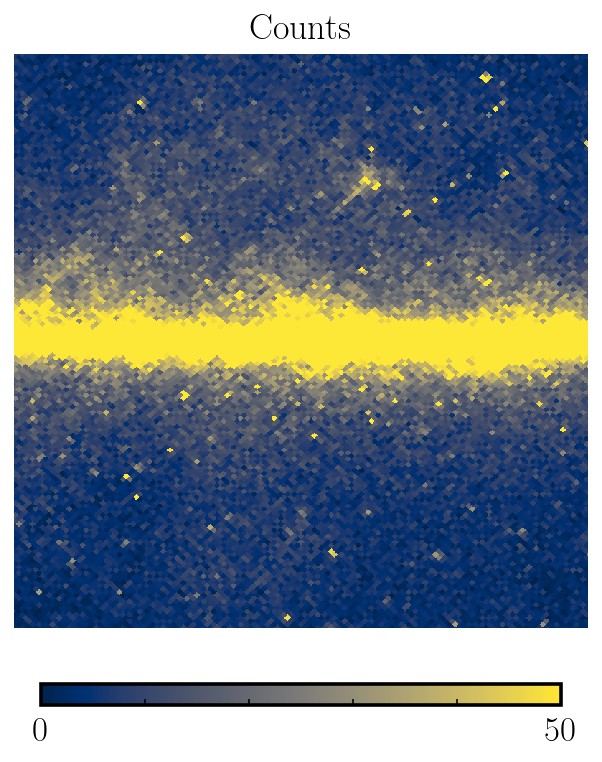

In [16]:
hp.cartview(np.load("../data/fermi_data/fermidata_counts.npy"), lonra=[-30,30], latra=[-30,30], min=0., max=50, nest=False, 
            title=r"Counts", cmap='cividis')

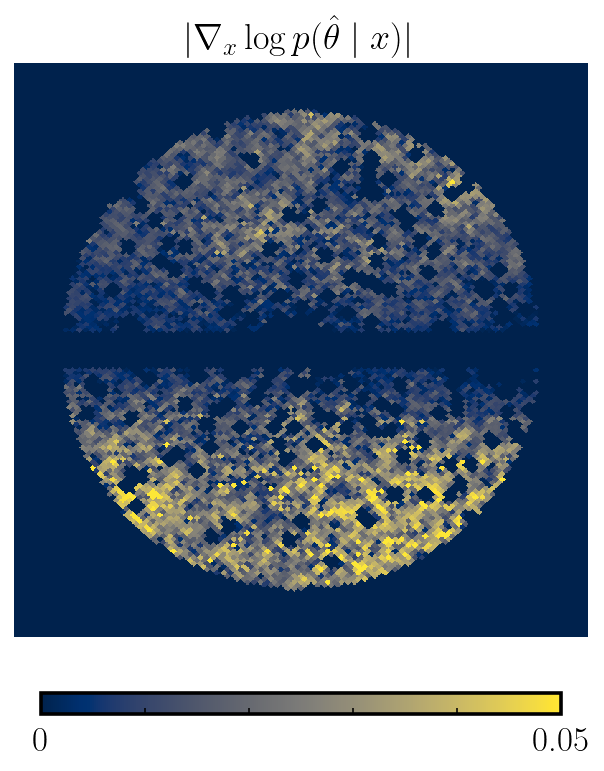

In [343]:
data_map.requires_grad = True

density_estimator.eval()

# inputs = samples.median(axis=1).values.detach()
inputs = samples.mean(axis=1).detach()
stds = samples.std(axis=1).detach()

inputs[0, 1] -= stds[0, 1]  # Iso
# inputs[0, 2] -= stds[0, 2]  # Bubbles

# inputs[0, 0] -= stds[0, 0]  # GCE
# inputs[0, 6] -= stds[0, 6]  # GCE PS

# inputs[0, 12] -= stds[0, 12]  # Disk PS

grad_x_log_prob = grad(density_estimator.log_prob(context=data_map, inputs=inputs),
            inputs=data_map,
#             grad_outputs=torch.ones_like(data_map),
            retain_graph=True)[0]

the_map = np.zeros(hp.nside2npix(128))
the_map[~masks_list[0]] = grad_x_log_prob[0,0].abs().detach().numpy()[:-2]
the_map[roi_mask] = 0.
hp.cartview(the_map, lonra=[-30,30], latra=[-30,30], min=0., max=0.05, nest=True, 
            title=r"$|\nabla_x\log p(\hat\theta\mid x)|$", cmap='cividis')

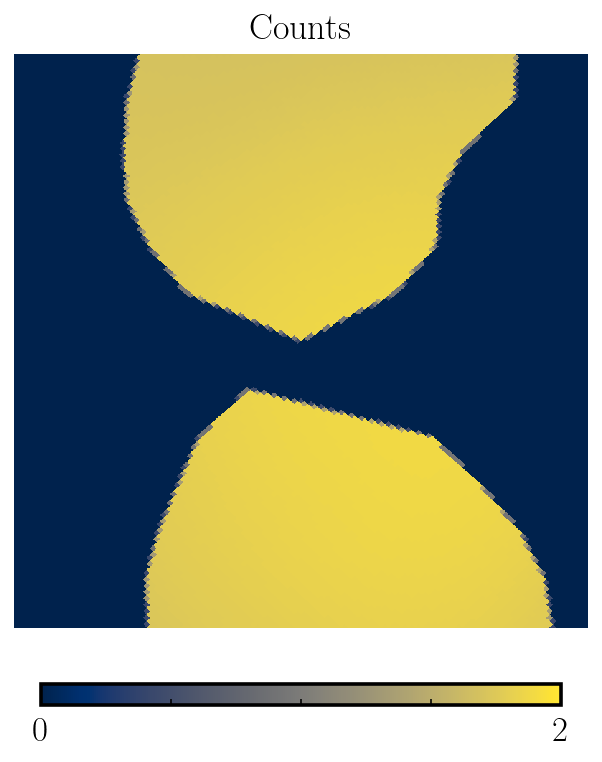

In [338]:
hp.cartview(np.load("../data/fermi_data/template_bub.npy"), lonra=[-30,30], latra=[-30,30], min=0., max=2, nest=False, 
            title=r"Counts", cmap='cividis')

## Simulations

In [78]:
x = torch.Tensor(np.load("../data/samples/x_ModelO_DM_only.npy"))
x_aux = torch.Tensor(np.load("../data/samples/x_aux_ModelO_DM_only.npy"))
theta = torch.Tensor(np.load("../data/samples/theta_ModelO_DM_only.npy"))

data_map = torch.cat([x, x_aux], axis=-1)[4].unsqueeze(0)

In [81]:
samples = density_estimator.sample(context=data_map, num_samples=5000)

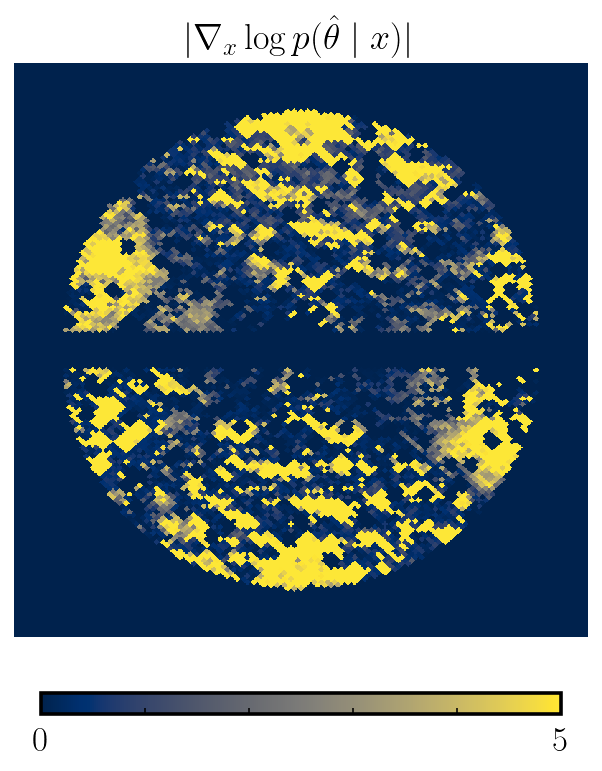

In [87]:
data_map.requires_grad = True

density_estimator.eval()

# inputs = samples.median(axis=1).values.detach()
inputs = samples.mean(axis=1).detach()
stds = samples.std(axis=1).detach()

# inputs[0, 1] -= stds[0, 1]  # Iso
inputs[0, 2] -= stds[0, 2]  # Bubbles

# inputs[0, 0] += stds[0, 0]  # GCE
# inputs[0, 6] -= stds[0, 6]  # GCE PS

# inputs[0, 12] -= stds[0, 12]  # Disk PS

grad_x_log_prob = grad(density_estimator.log_prob(context=data_map, inputs=inputs),
            inputs=data_map,
#             grad_outputs=torch.ones_like(data_map),
            retain_graph=True)[0]

the_map = np.zeros(hp.nside2npix(128))
the_map[~masks_list[0]] = grad_x_log_prob[0,0].abs().detach().numpy()[:-2]
the_map[roi_mask] = 0.
hp.cartview(the_map, lonra=[-30,30], latra=[-30,30], min=0., max=5, nest=True, 
            title=r"$|\nabla_x\log p(\hat\theta\mid x)|$", cmap='cividis')